# PART 4: Modelling

After EDA, let's modelling our data to do prediction

In [2]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import uuid
import time
from datetime import datetime
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

### Importing our data

Let's start by importing our data at `pre-processed/filtered_features.csv`

In [3]:
dataset = pd.read_pickle("../data/processed/final_sm.pkl")
dataset.head()

,AGE,ALCOHOL CONSUMING,ALLERGY,CHEST PAIN,WHEEZING,LUNG_CANCER
0,69,1,0,1,1,1
1,74,0,1,1,0,1
2,59,0,0,1,1,0
3,63,1,0,1,0,0
4,63,0,0,0,1,0


### Modelling approach

From this data above, I will use `Decision Tree` Classification algorithm.

Why ?

1. The data is non-linear datasets
2. The data is mostly a boolean value, which mean is binary data

### Splitting the data

Now we already has the ready to predict data, we already doing

1. Pre-processed
2. EDA
3. Oversampling to handle imbalance


Let's start the next step with `Splitting the data` into test and train

In [4]:
X = dataset.drop(columns=["LUNG_CANCER"], axis=1).values
y = dataset["LUNG_CANCER"].copy().values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120)

Now we already split the train and test data.

Let's continue on the next step

### Creating logging function

This will be use to log the model training process.

The purposes is to keep track on the logging process of the model we trained, to easier spotting bugs or anomaly performances.

In [5]:
from tabulate import tabulate


def logging(log):
    return {
        "model_uid": log["model_uid"],
        "model_name": log["model_name"],
        "training_time": log["training_time"],
        "training_date": log["training_date"],
        "recall": log["recall"],
        "f1_score": log["f1_score"],
        "data_config": log["data_config"],
        "confusion_matrix": log["confusion_matrix"]
    }
    
def create_log(log):
    with open("../log/log.txt", "a+") as file:
        try:
            tableText = tabulate([log.values()], headers=log.keys())
            file.write(tableText)
            file.write("\n \n")
        except Exception as e:
            print(e)
            pass
        

### Scaling the features

Because the age has a big variance, we need to make it in a same scale with other features as well.

We will use StandardScaler for this, to track from it's mean and std

In [6]:
# Declaring logs
log = {}
log["model_uid"] = uuid.uuid4()
log["training_date"] = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
log["data_config"] = "smote"
start = time.time()


# StandardScaler object
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model fitting

Now we need to train the model using the fitting method from `Decision Tree` classifier

In [7]:
classifier = DecisionTreeClassifier(criterion="gini", max_depth=3)
log["model_name"] = classifier.__class__

classifier.fit(X_train, y_train)

end = time.time()
log["training_time"] = end - start

y_pred = classifier.predict(X_test)

### Attribute Selection

Because we're doing the model training using `Decision Tree` Classifier, we need to know which features we will start to use to split.

From the model above we use "GINI INDEX" as criterion, let's plot the decision tree to be able to analyze

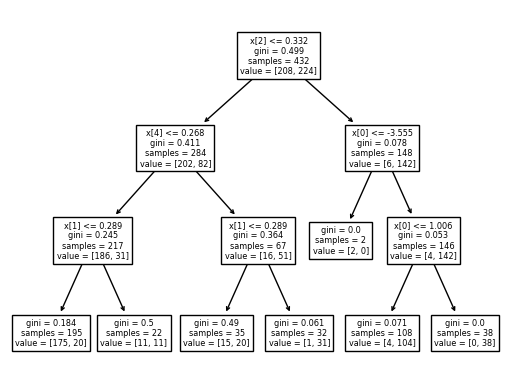

In [8]:
tree.plot_tree(classifier)
plt.show()

### Model metrics

Let's check the metrics of the model, we need to know

1. Recall
2. F1 Score
3. Confusion Matrix

In [9]:
recall = metrics.recall_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

log["recall"] = recall
log["f1_score"] = f1_score
log["confusion_matrix"] = confusion_matrix

print("Recall:", recall)
print("F1 Score:", f1_score)
print("Confusion Metrics:", confusion_matrix)

Recall: 0.6521739130434783
F1 Score: 0.75
Confusion Metrics: [[58  4]
 [16 30]]


Recall has a range around 0.65, which is pretty big and accurrate

F1 Score has a range around 0.75, pretty accurrate too

Let's plot our Confusion metrics to understand the error

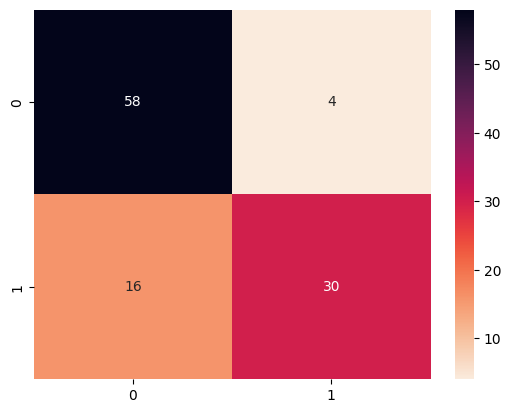

In [10]:
sns.heatmap(confusion_matrix, cmap="rocket_r", annot=True)
plt.show()

TN ( True Negative ) = Top Left corner

FP ( False Positive ) = Top Right corner 

FN ( False Negative ) = Bottom Left corner

TP ( True Positive ) = Bottom Right corner

Which mean we have 16 False Negative, which failed to predict 16 people has LUNG CANCER althought the person has it

### Saving log data

We already save the log of the performances into `log` object, let's save the log

In [11]:
save_log = logging(log)
create_log(save_log)

### Saving model to pickle

Let's save the model to pickle file into `models/decision_tree.pkl`

We want to consume the model from the API, we can use to predict the data

In [12]:
modelname = "../models/decision_tree.pkl"
scalername = "../models/decision_tree_scaler.pkl"
pickle.dump(classifier, open(modelname, "wb"))
pickle.dump(sc, open(scalername, "wb"))

### Testing Pickle model

Let's testing pickle model to predict data

In [14]:
dt = pickle.load(open(modelname,"rb"))
dt_sc = pickle.load(open(scalername,"rb"))

dummy = [[62, 1, 1, 0, 0]]
dummy = dt_sc.transform(dummy)

pred = dt.predict(dummy)
pred

array([1], dtype=int64)